# Описание проекта
Компания-разработчик развлекательного приложения Procrastinate Pro+, тратит большие деньги на привлечение новых пользователей,однако эти вложения не окупаются. Маркетинговый отдел прислал нам данные о рекламных затратах, о посещения пользователей , и об их покупках и попросил разобраться в чем причина неокупаемости вложенных в рекламу денег. 

Цели Исследования:
- составить портрет пользователя
- определить стоимость привлечения клиентов;
- определить сколько денег приносит каждый клиент
- определить причины неэффективности маркетинговой деятельности

План исследования:
- 1.загрузка данных
- 2.предобработка данных
- 3.написать вспомогательный функции для анализа
- 4.провести анализ пользователей(регион,девайс,канал привлечения
- 5.провести анализ маркетинговой деятельности
- 6.выяснить причины неокупаемости рекламы
- 7.написать общий вывод

### Загрузим данные и подготовьте их к анализу

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import warnings
warnings.simplefilter('ignore')


In [2]:
try:
    visits = pd.read_csv("C:/Users/kulum/Downloads/visits_info_short.csv")
    orders = pd.read_csv("C:/Users/kulum/Downloads/orders_info_short.csv")
    costs = pd.read_csv("C:/Users/kulum/Downloads/costs_info_short.csv")
except:
    visits = pd.read_csv("https://code.s3.yandex.net/datasets/visits_info_short.csv")
    orders = pd.read_csv("https://code.s3.yandex.net/datasets/orders_info_short.csv")
    costs = pd.read_csv("https://code.s3.yandex.net/datasets/costs_info_short.csv")
    
    

In [3]:
display(visits.head())
display(orders.head())
costs.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [4]:
orders.info(), costs.info(), visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  objec

(None, None, None)

Перед нами 3 таблицы orders, costs, visits, в которых нет пропусков,  но в столбцах - Session Start, Session End,Event Dt,dt - изменим тип данных с 'object' на 'datetime', а также приведем все названия столбцов к нижнему регистру и заменим пропуски на "_".

In [5]:
visits.columns = (visits.rename(
    columns = {'Session Start': 'session_start','User Id': 'user_id',
    'Session End': 'session_end'}).columns.str.lower()
                 )
orders.columns = (orders.rename(columns = {'User Id': 'user_id',
                'Event Dt': 'event_dt'}).columns.str.lower())
costs.columns = costs.columns.str.lower()

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

display(visits.head(1))
display(orders.head(1))
costs.head(1)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3


In [6]:
#Также проверим таблицы на наличие дубликатов
visits.duplicated().sum(), orders.duplicated().sum(), costs.duplicated().sum()

(0, 0, 0)

### Определим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

In [7]:
def get_profiles(visits, orders,costs):
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [8]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [9]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time



In [10]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
 
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
 
    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
 
        # собираем датафрейм с данными пользователей и значениями CAC,
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
 
        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
 
        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)
 
        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]
 
        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes
 
        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']
 
        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
 
        # возвращаем таблицы LTV и ROI
        return result, roi
 
    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
 
    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
 
    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
 
    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [12]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(30, 15))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV', fontsize=25)

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon), fontsize=25)

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей', fontsize=25)


    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI', fontsize=25)

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon), fontsize=25)
    
    plt.tight_layout()
    plt.show()

In [13]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(30, 10))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()#bbox_to_anchor=(1.0, 1.05), loc='upper left')
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [14]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(30, 20))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [15]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(30, 15))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV', fontsize=25)

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon), fontsize=25)

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей', fontsize=25)


    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI', fontsize=25)

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon), fontsize=25)
    
    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

####  Определим минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [16]:
profile  = get_profiles(visits,orders,costs)
min_date = profile.first_ts.min().date()
max_date = profile.first_ts.max().date()
print('Максимальная дата привлечения -', max_date,
      '\nМинимальная дата привлечения -', min_date )



Максимальная дата привлечения - 2019-10-27 
Минимальная дата привлечения - 2019-05-01


По условию мы смотрим данные 2019-11-01, однако данные представлены только до 2019-10-27, значит эту дату мы и  будем использовать как максимальную

#### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.

In [17]:
profile_region = profile.groupby('region').agg({'user_id':'nunique'}).reset_index()
profile_region['payer_user'] = profile[profile.payer == True].groupby('region').agg({'user_id':'nunique'}).reset_index()['user_id']
profile_region['ratio'] = round( profile_region['payer_user']/profile_region['user_id']*100,2)
profile_region

,region,user_id,payer_user,ratio
0,France,17450,663,3.80
1,Germany,14981,616,4.11
2,UK,17575,700,3.98
3,United States,100002,6902,6.90


Приложением пользуются жители 4 стран : Франции, Германии, Великобритании , США. Наибольшее количество платящих и неплатящих пользоветелей  из США . Лучшее соотношение платящих пользователей ко всем также у США

#### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 

In [18]:
profile_device = profile.groupby('device').agg({'user_id':'nunique'}).reset_index()
profile_device['payer_user'] = (profile[profile.payer == True].groupby('device')
                                .agg({'user_id':'nunique'}).reset_index()['user_id'])
profile_device['ratio'] = round(profile_device['payer_user']/profile_device['user_id']*100,2)
profile_device

,device,user_id,payer_user,ratio
0,Android,35032,2050,5.85
1,Mac,30042,1912,6.36
2,PC,30455,1537,5.05
3,iPhone,54479,3382,6.21


Пользователи приложения "Procrastinate Pro+" предпочитают пользоваться устройствами работающими на платформе андроид, мак, айфон, и ПК.Большинство пользователей используют продукцию эпл. Большинство платящих полоьзователей использует айфон. Лучшее соотношение платящих пользователей ко всем у мака , худшее у ПК.

#### Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [19]:
profile_channel = profile.groupby('channel').agg({'user_id':'nunique'}).reset_index()
profile_channel['payer_user'] = (profile[profile.payer == True]
        .groupby('channel').agg({'user_id':'nunique'}).reset_index()['user_id'])

profile_channel['ratio'] = round(profile_channel['payer_user']/profile_channel['user_id']*100,2)
profile_channel.sort_values( by = 'payer_user' ,  ascending = False)

,channel,user_id,payer_user,ratio
1,FaceBoom,29144,3557,12.20
6,TipTop,19561,1878,9.60
10,organic,56439,1160,2.06
7,WahooNetBanner,8553,453,5.30
0,AdNonSense,3880,440,11.34
5,RocketSuperAds,4448,352,7.91
2,LeapBob,8553,262,3.06
4,OppleCreativeMedia,8605,233,2.71
9,lambdaMediaAds,2149,225,10.47
8,YRabbit,4312,165,3.83


Больше всего пользователей пришло органическим трафиком , меньше всего из lambdaMediaAds,если смотреть по платящим пользователям , то больше всего пришло из faceboom, меньше всего из MediaTornado.  Лучшее соотношение платящих пользователей ко всем у faceboom и AdNonSense , худшее у OppleCreativeMedia, MediaTornado и YRabbit.

#### вывод

Минимальная дата привлечения пользователей - 1 мая 2019 г. Максимальная дата с учетом горизонта - 27 октября 2019 г.
Приложением пользуются жители 4 стран: Великобритания,США, Франция и Германия. На США приходятся больше всего пользователей, более 100 тыс.Также в США больше всего платящих пользователй и эта страна имеет самую высокую долю платящих пользователей.
Пользователи заходят в приложение с таких устровств , как Android, iPhone, Mac и PС. Больше всего пользователей как платящих , так и обычных приходится на iPhone.
Больше всего пришло пользователей органическим путем.Среди каналов наиболее популярным у наших пользователей является FaceBoom, затем TipTop, наименее популярными каналами являются OppleCreativeMedia, MediaTornado и YRabbit.

### Маркетинг

#### Посчитаем общую сумму расходов на маркетинг.

In [20]:
round(profile.acquisition_cost.sum(),1)

105497.3

Общая сумма расходов на маркетинг с 1  мая по 27 октября 2019 года составила  105497.3 $

#### Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [21]:
profile.groupby('channel').agg({'acquisition_cost': 'sum'}).sort_values(by = 'acquisition_cost' , ascending = False)

,acquisition_cost
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Больше всего потратили на источник 'TipTop', затем Faceboom,меньше всего на MediaTornado и YRabbit

#### Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.


Text(0, 0.5, 'Расходы')

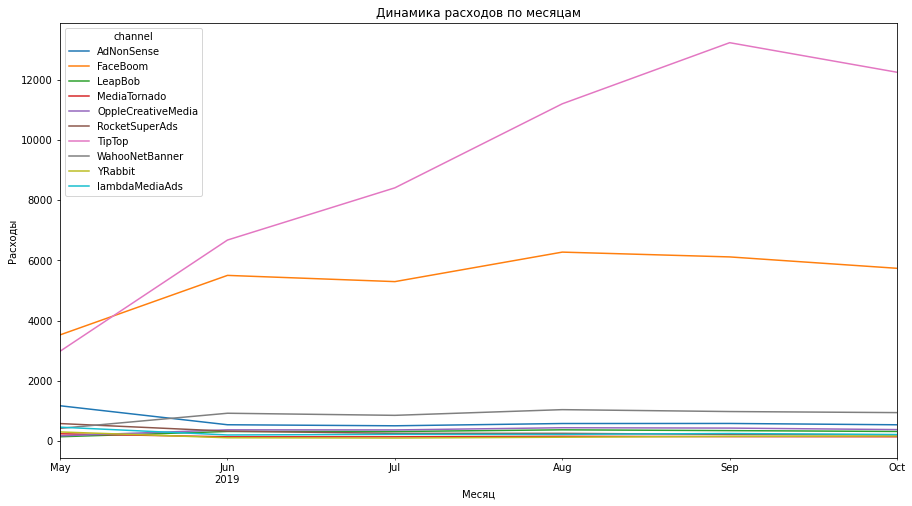

In [22]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs.pivot_table(index = 'month',columns = 'channel' ,values = 'costs', aggfunc = {'sum'}).droplevel(0,1).plot(figsize = (15,8))
plt.title('Динамика расходов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы')

Расходу на канал TipTop с мая стремительно растут и в сентябре уходят выше 12000 , у FaceBoom также с мая растут расходы и затем держатся в районе  5500 . У остальных источников без особых изменений с мая по сентябрь , их расходы держатся на уровне до 1000$.

Text(0, 0.5, 'Расходы')

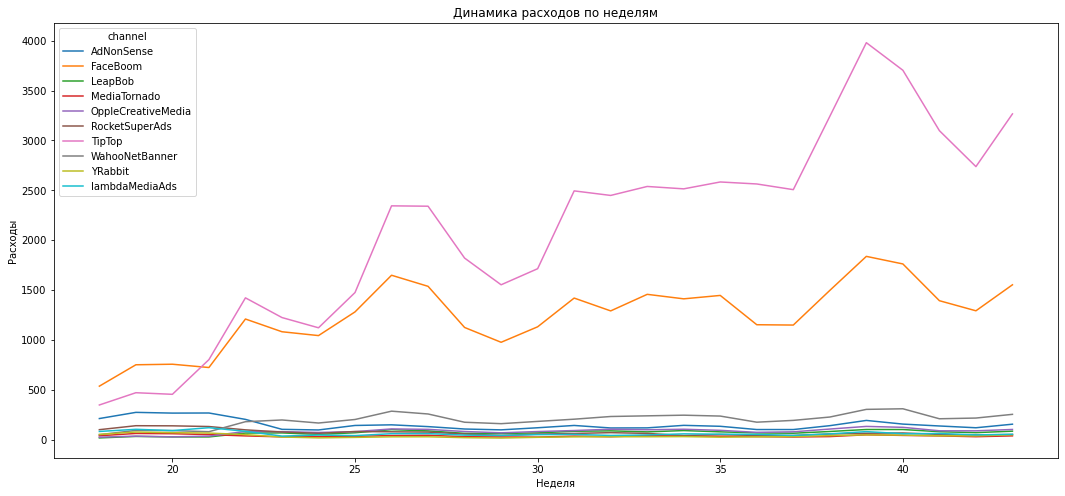

In [23]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs.pivot_table(index = 'week',columns = 'channel' ,values = 'costs', aggfunc = {'sum'}).droplevel(0,1).plot(figsize = (18,8))
plt.title('Динамика расходов по неделям')
plt.xlabel('Неделя')
plt.ylabel('Расходы')

С 20 недели наблюдается резкий скачок по затратам у TipTop, на 38 неделе сумма доходит  до 4000, у FaceBoom в среднем расходы держатся между 750 и 1500 , больше 1500 было на 38 и 39 неделе, у остальный расходы держатся на уровне до 500

In [24]:
(profile.groupby('channel').agg({'acquisition_cost': 'mean'}).reset_index()
.sort_values( by = 'acquisition_cost', ascending = False).round(2))

,channel,acquisition_cost
6,TipTop,2.80
1,FaceBoom,1.11
0,AdNonSense,1.01
9,lambdaMediaAds,0.72
7,WahooNetBanner,0.60
5,RocketSuperAds,0.41
4,OppleCreativeMedia,0.25
8,YRabbit,0.22
3,MediaTornado,0.22
2,LeapBob,0.21


#### Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

In [25]:
print("Средний САС по проекту - ",
      round((profile.groupby('channel')
      .agg({'acquisition_cost': 'mean'}).reset_index()
      .sort_values( by = 'acquisition_cost', ascending = False)
        .round(2))['acquisition_cost'].mean(),3),
      '\nСредний САС в {} меньше у чем TipTop'.format(round(2.8/0.75,1)))

Средний САС по проекту -  0.686 
Средний САС в 3.7 меньше у чем TipTop


#### Вывод

Компания в период с 1 мая по 27 октября 2019 года потратила на привлечение клиентов 105497.3 $. Больше всего компания заплатила TipTop - 54751 и FaceBoom - 32445 $/ Меньше всего MediaTornado - 954 $ и YRabbit - 944. Расходы на привленчение клиентов стремительно росли с мая по октябрь, особенно TipTop и FaceBoom , расходы остальных каналов ни сильно изменились . Один пользователь из TipTop стоит 2.8 , из FaceBoom - 1.11, меньше всего YRabbit - 0.22, MediaTornado - 0.22, LeapBob - 0.21

Наиболее дорогостоящим каналом привлечения пользователей является TipTop, однако количество и доля платящих пользователей, приходящих с этого источника, не так высоки. Это можно объяснить молодой аудиторией TipTop'a и, соответственно, не очень высокой их платежеспособностью.
    

### Оценим окупаемость рекламы


#### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

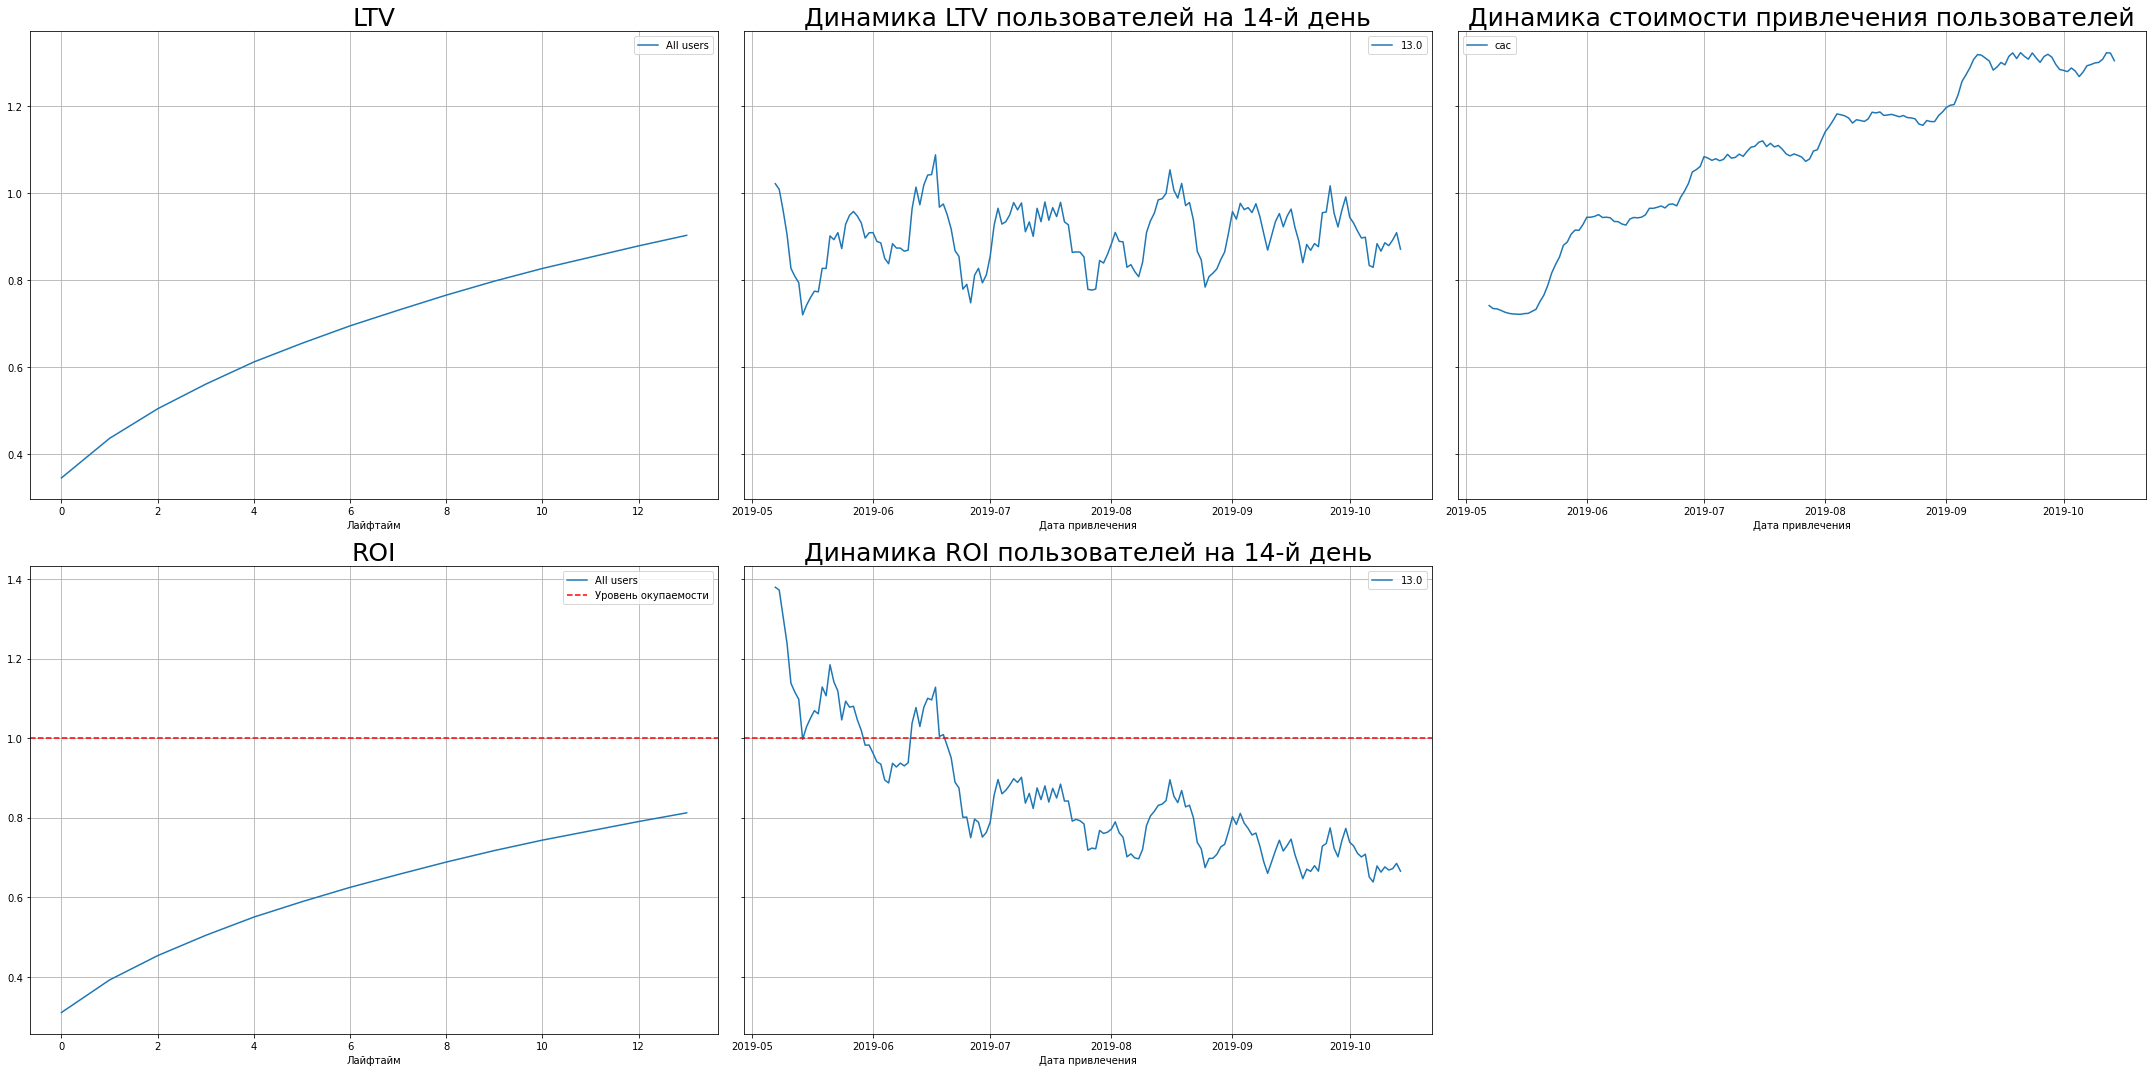

In [26]:
horizon_days = 14
observation_date = max_date
profile = profile.query('channel != "organic"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profile, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 


Судя по графику ROI , затраты на привлечение клиентов не окупается. Скорее всего, это связано с увеличением расходов на привлечение клиентов с июня месяца.


#### Проверьте конверсию и ретеншн пользователей и динамику её изменения. 

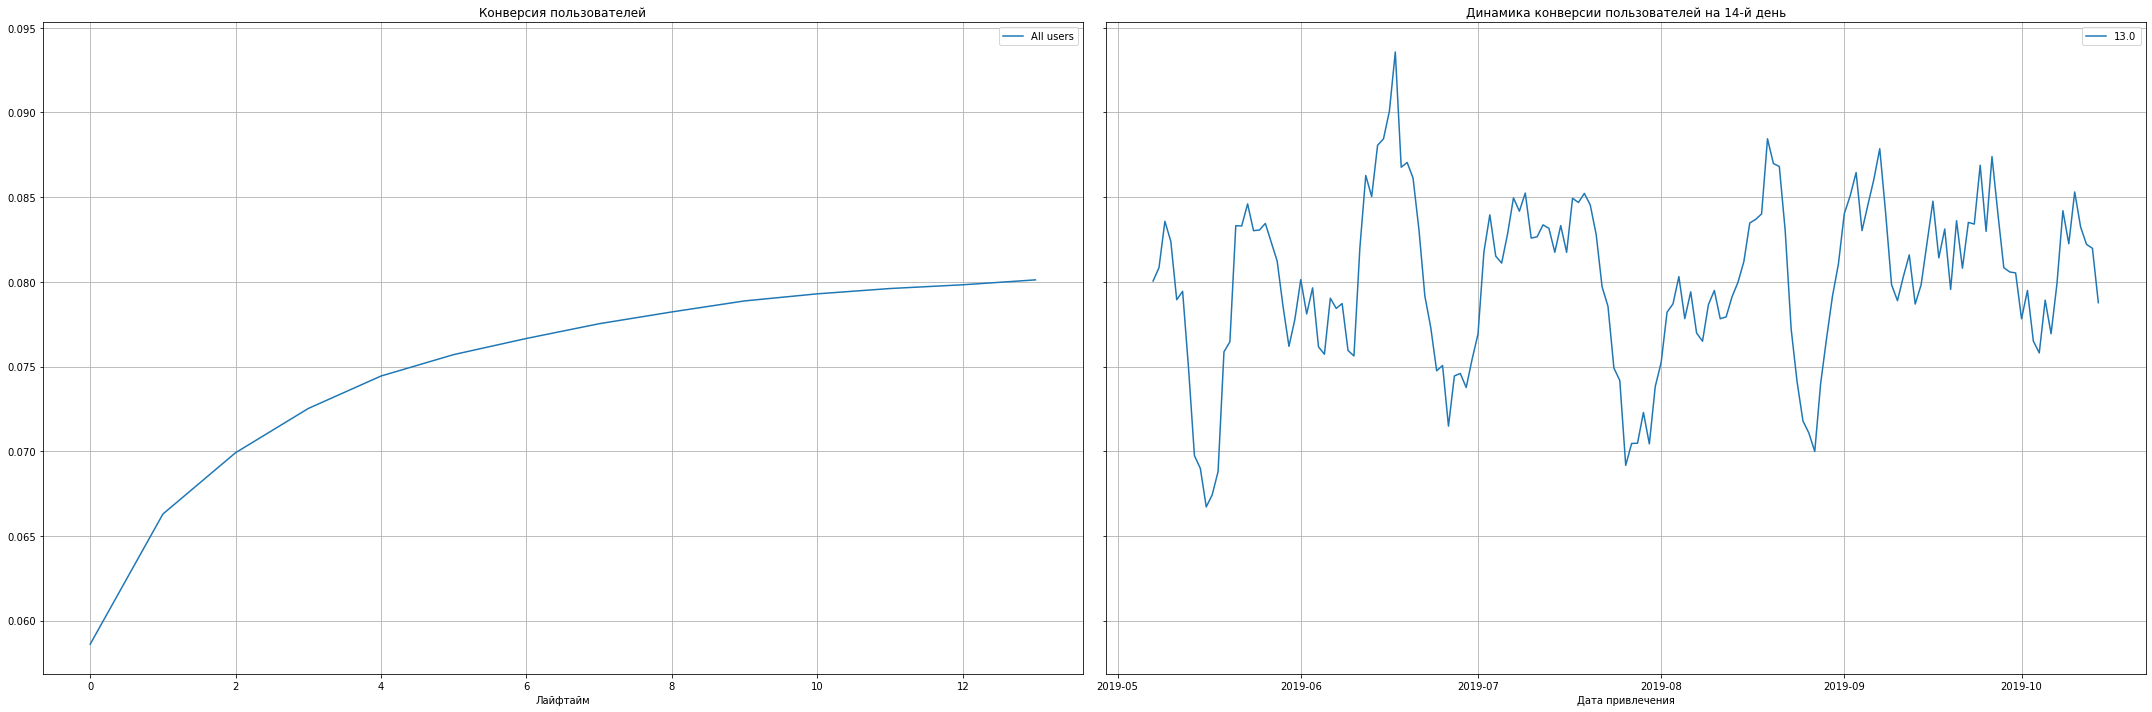

In [27]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profile, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

К концу лайфтайма только 8 процентов пользователей совершили покупку

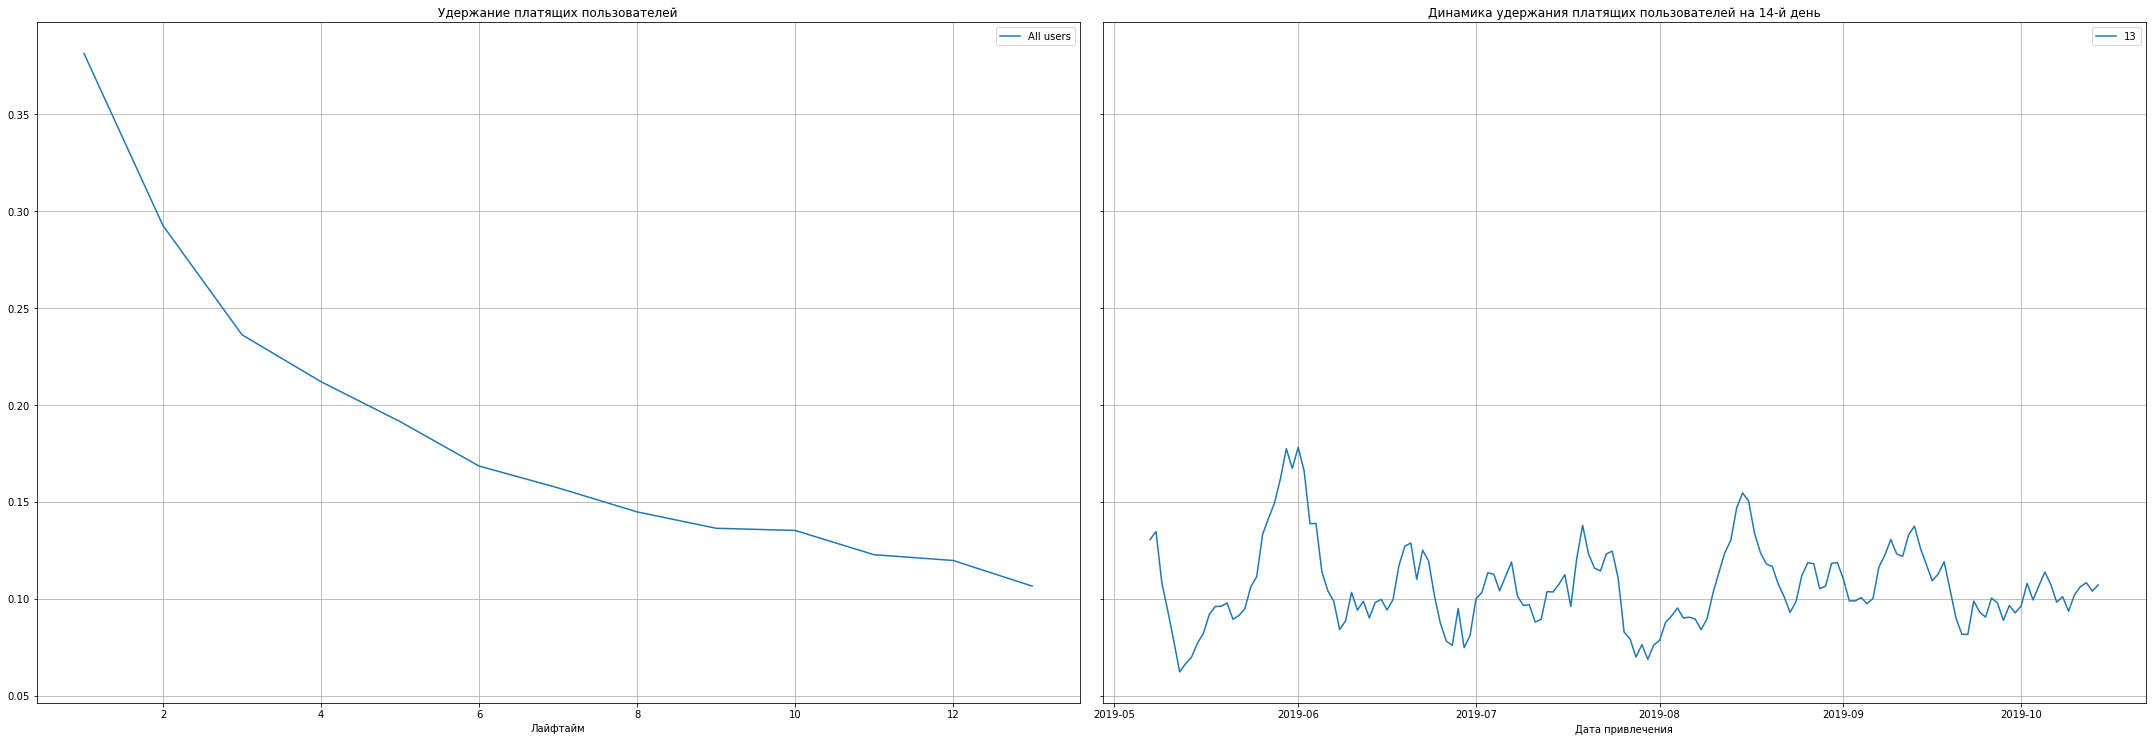

In [28]:
retention_raw, retention_grouped, retention_history = get_retention(
    profile, visits, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days)

К 14 дну остается только 11 % процентов пользователей   от 1 дня

#### Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

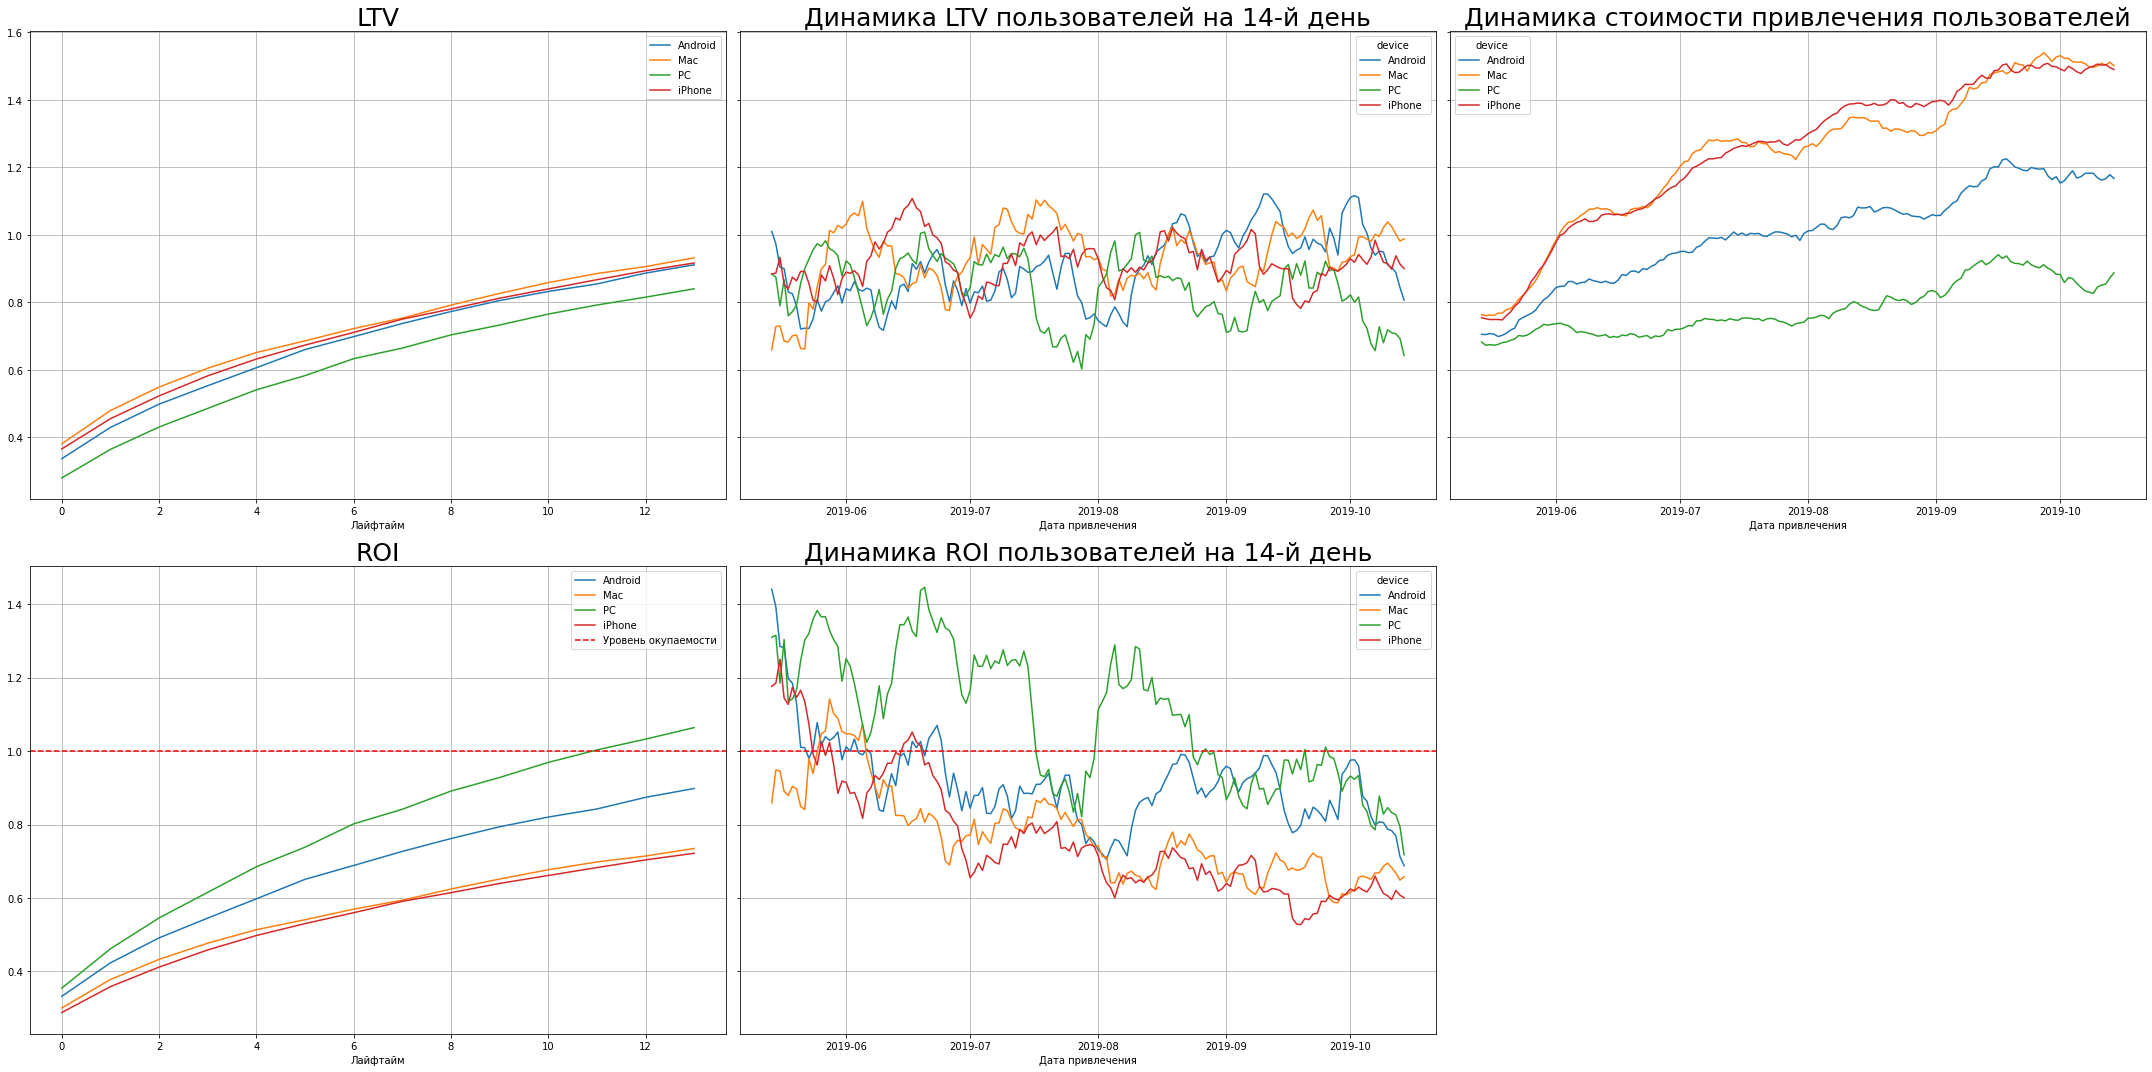

In [29]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profile, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Из всех девайсов только пользователи ПК преодолели точку безубыточности. Скорее всего это связано с тем, что расходы на привлечение пользователей у ПК значительно ниже , чем у пользователей других платформ 


#### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.


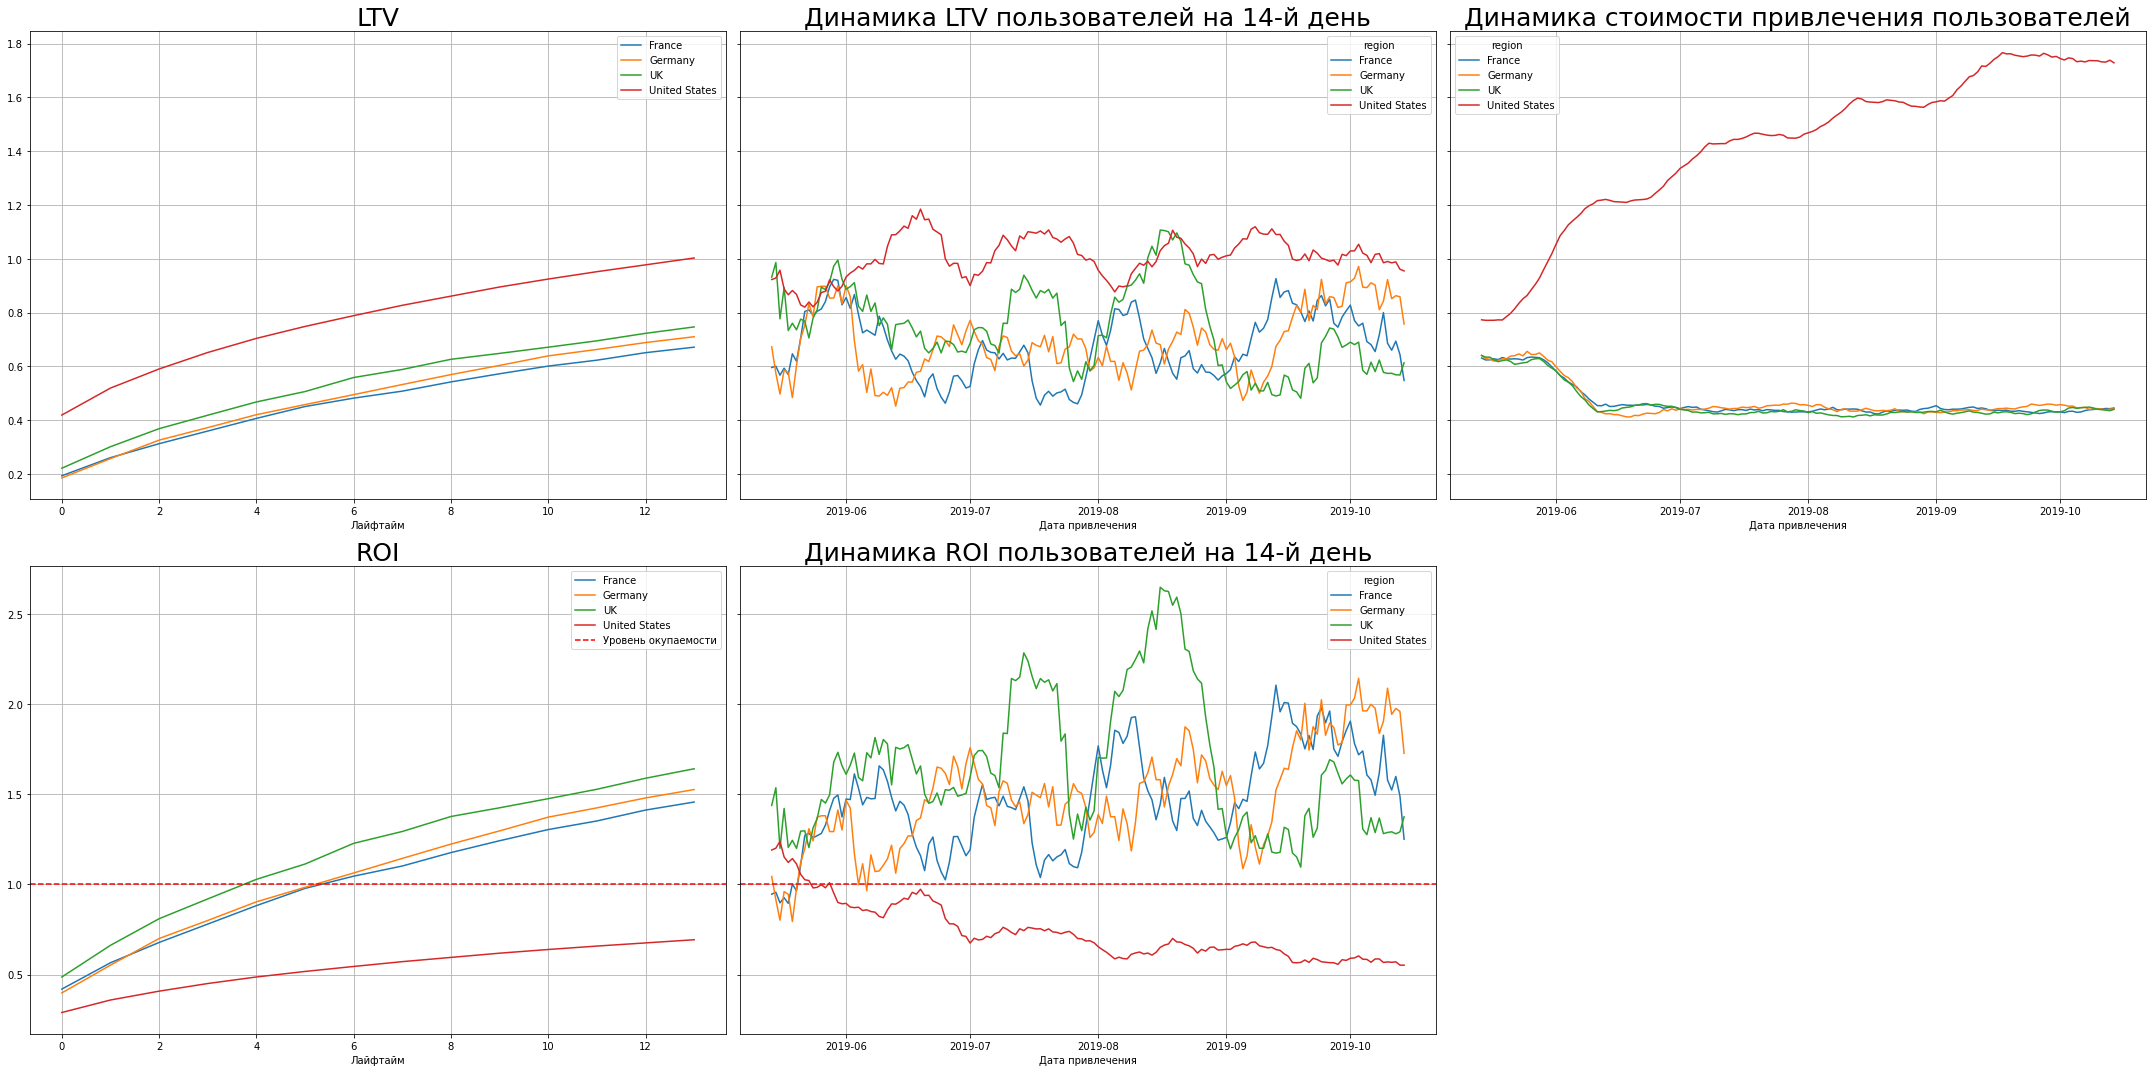

In [30]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profile, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


Из всех стран только у США не окупается , при чем разница с остальными страна существенная. Связано это с тем, что стоимость привлечения клиента в сша сильно выросла с июня месяца  

#### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

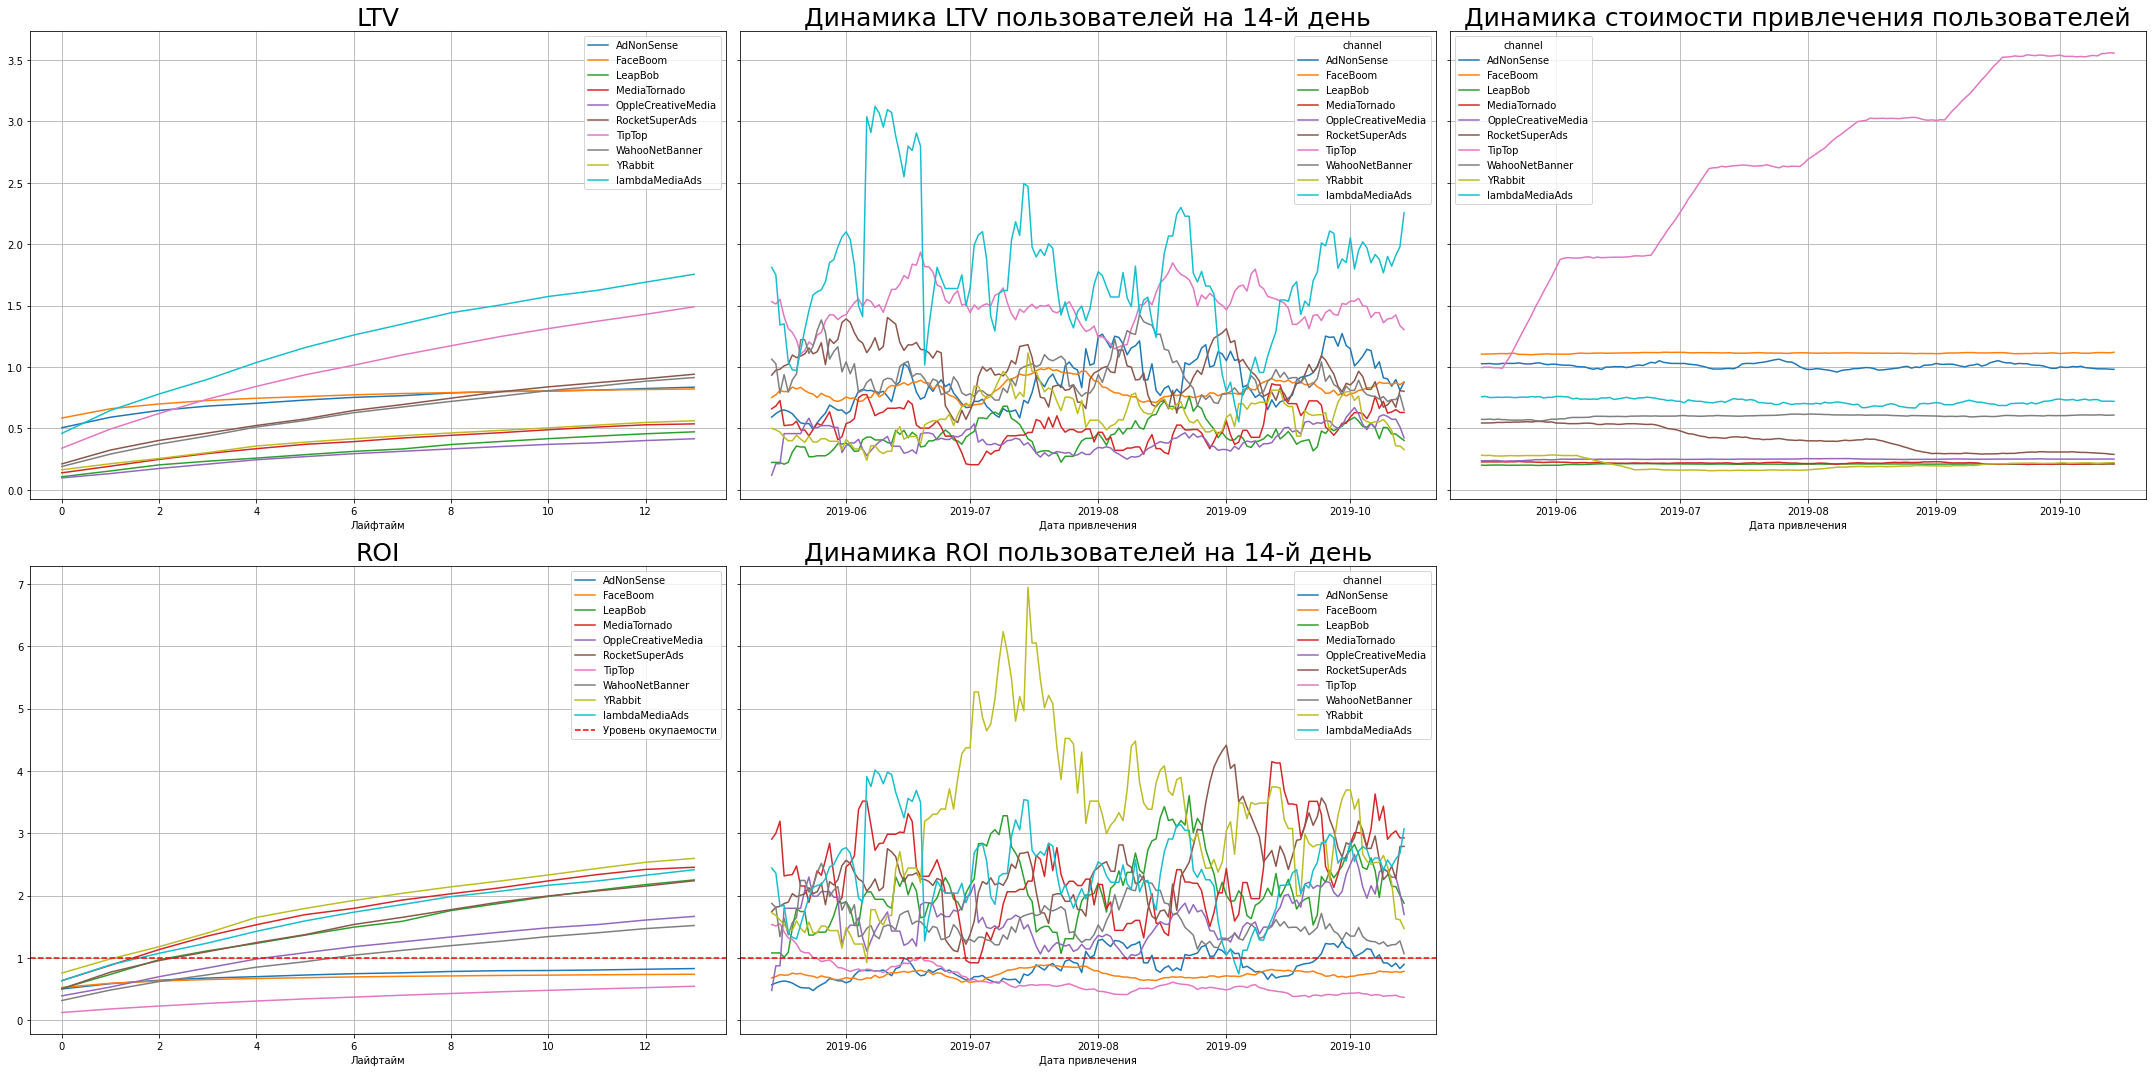

In [31]:

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profile, orders, observation_date, horizon_days, dimensions= ['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Только каналы TipTop, AdNonSense, FaceBoom не окупились . Скорее всего , из-за стоимости привлечения , особенно это касается TipTop. Самый выский ROI показли YRabbit,MediaTornado,lambdaMediaAds,LeapBob,RocketSuperAds

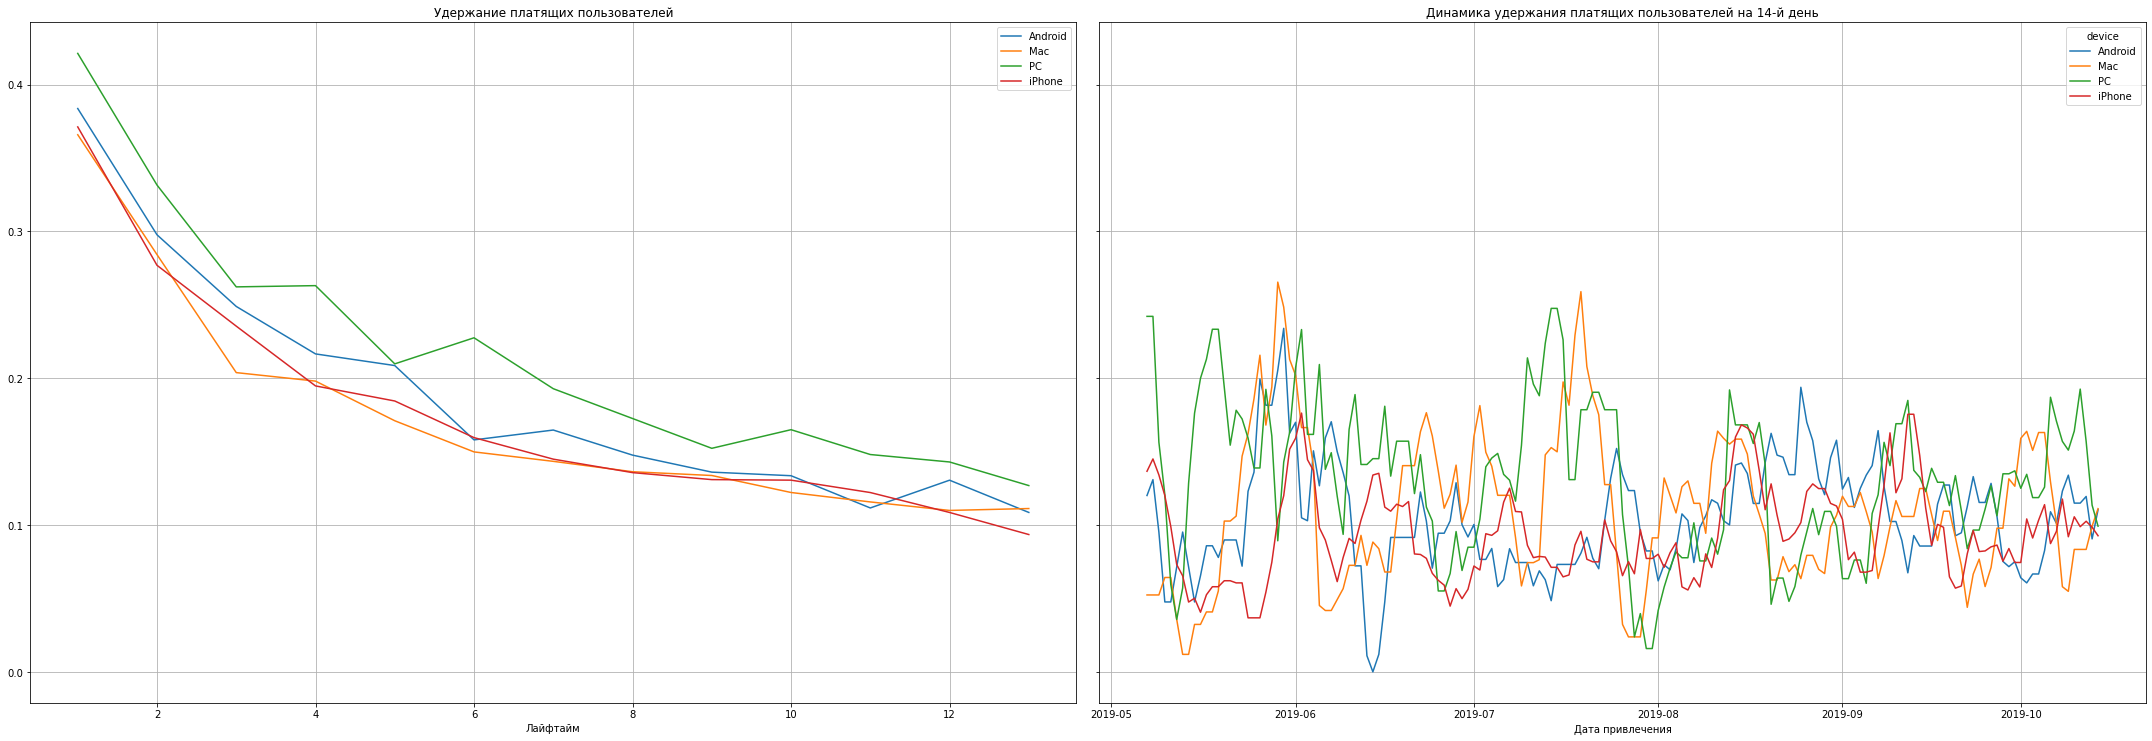

In [32]:
retention_raw, retention_grouped, retention_history = get_retention(
    profile, visits, observation_date, horizon_days,dimensions = ['device'])

plot_retention(retention_grouped, retention_history, horizon_days)



Лучше всего удерживаются платящие пользователи ПК, к 14 дню остается около 13 % процентов, Андроид и МАК примерно на одном уровне, хуже всего у пользователей Айфона

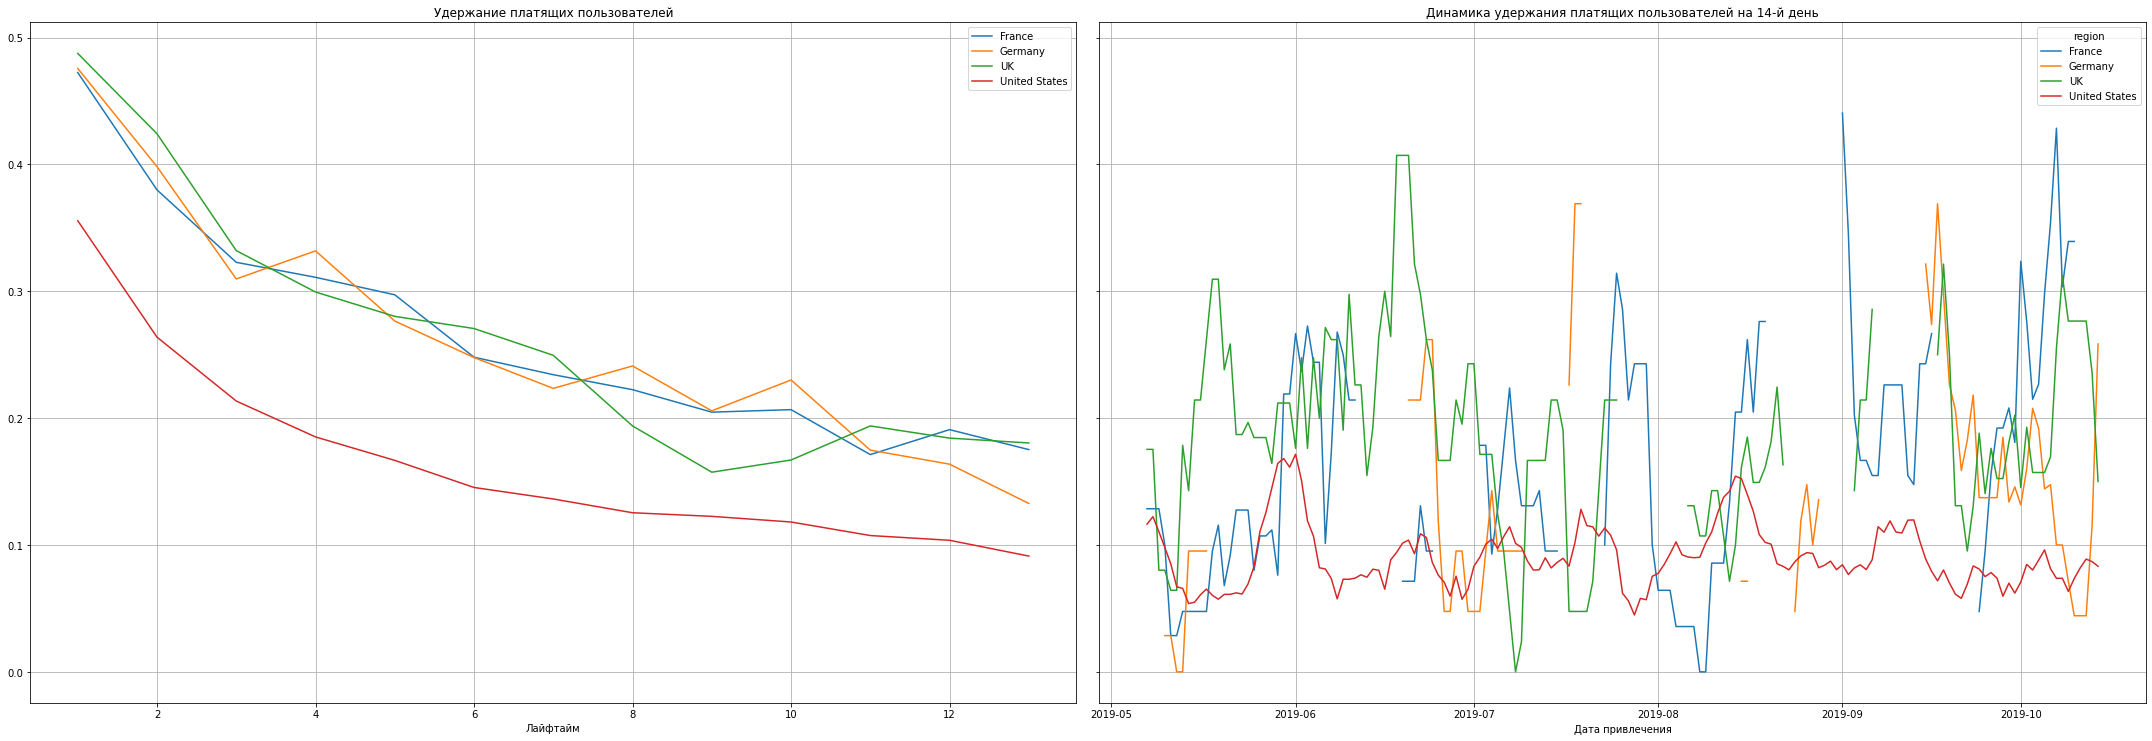

In [33]:
retention_raw, retention_grouped, retention_history = get_retention(
    profile, visits, observation_date, horizon_days,dimensions = ['region'])

plot_retention(retention_grouped, retention_history, horizon_days)

Самый высокий ретеншн у Франции и Великоьритании, около 18 процентов пользователей остается к концу лайфтайма,затем идет Германия , около 13%, и самый низкий у США ,меньше 10% 

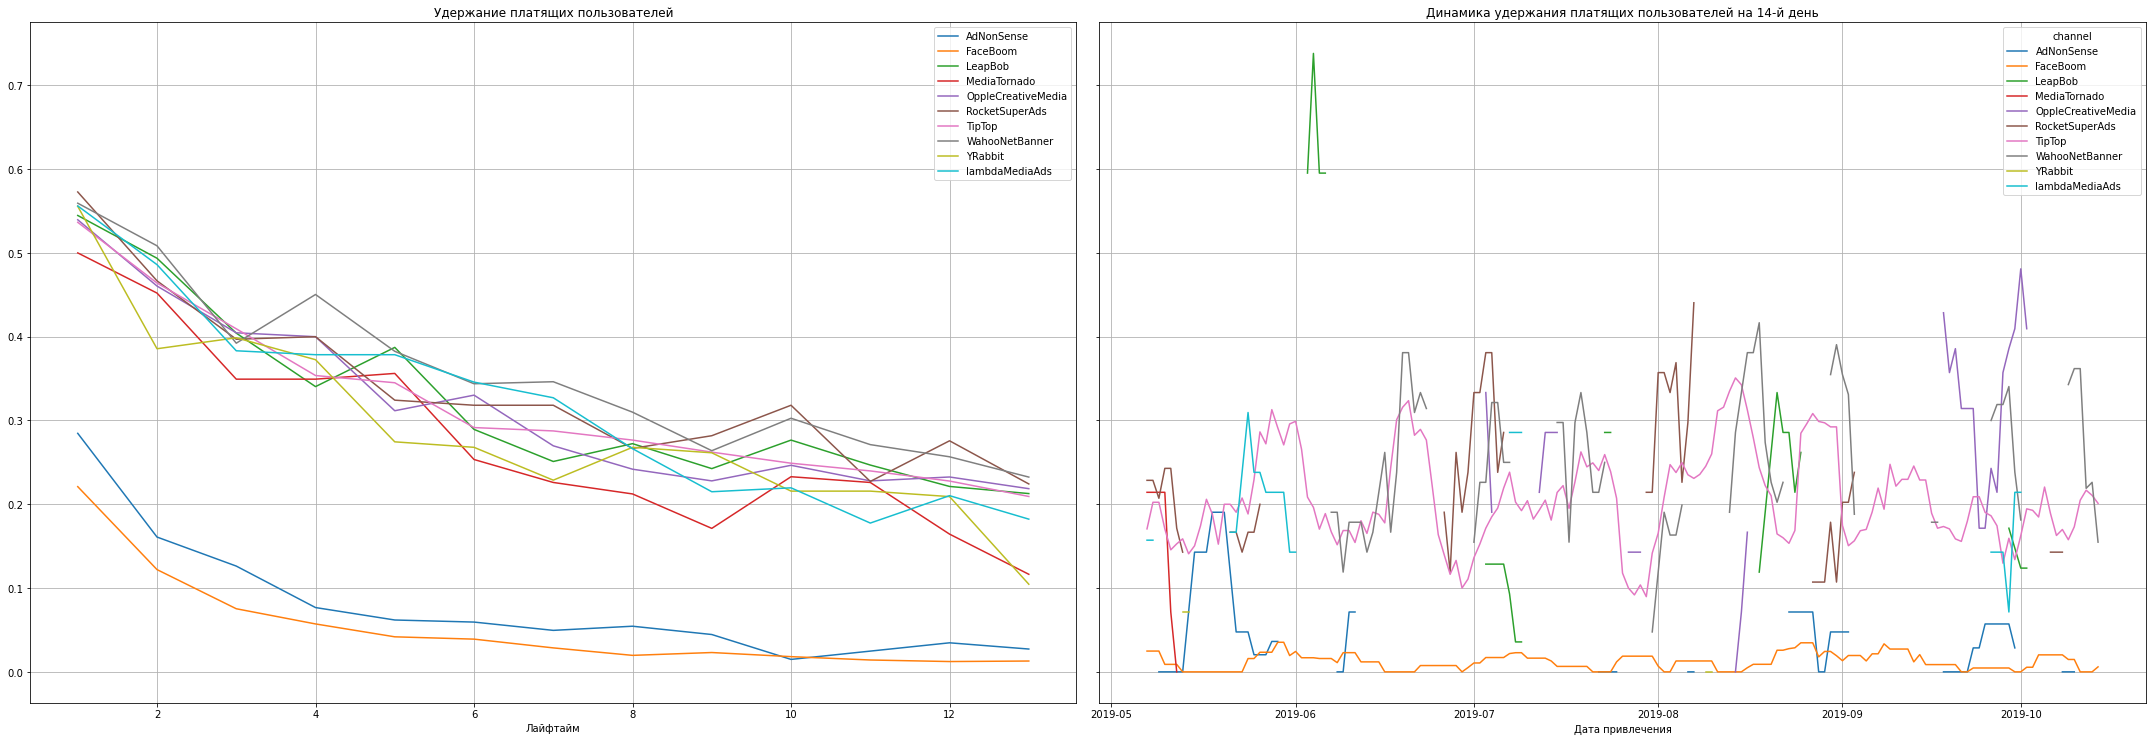

In [34]:
retention_raw, retention_grouped, retention_history = get_retention(
    profile, visits, observation_date, horizon_days,dimensions = ['channel'])

plot_retention(retention_grouped, retention_history, horizon_days)

Самый высокий ретеншен на 14 день у каналов WahooNetBanner, RocketSuperAds, OppleCreativeMedia, LeapBob, TipTop примерно одинаковый и держется на уровне 20 процентов,а вот у пользователей AdNonSense, FaceBoom самый низкий , у первого 2,7%, у второго 1,2%

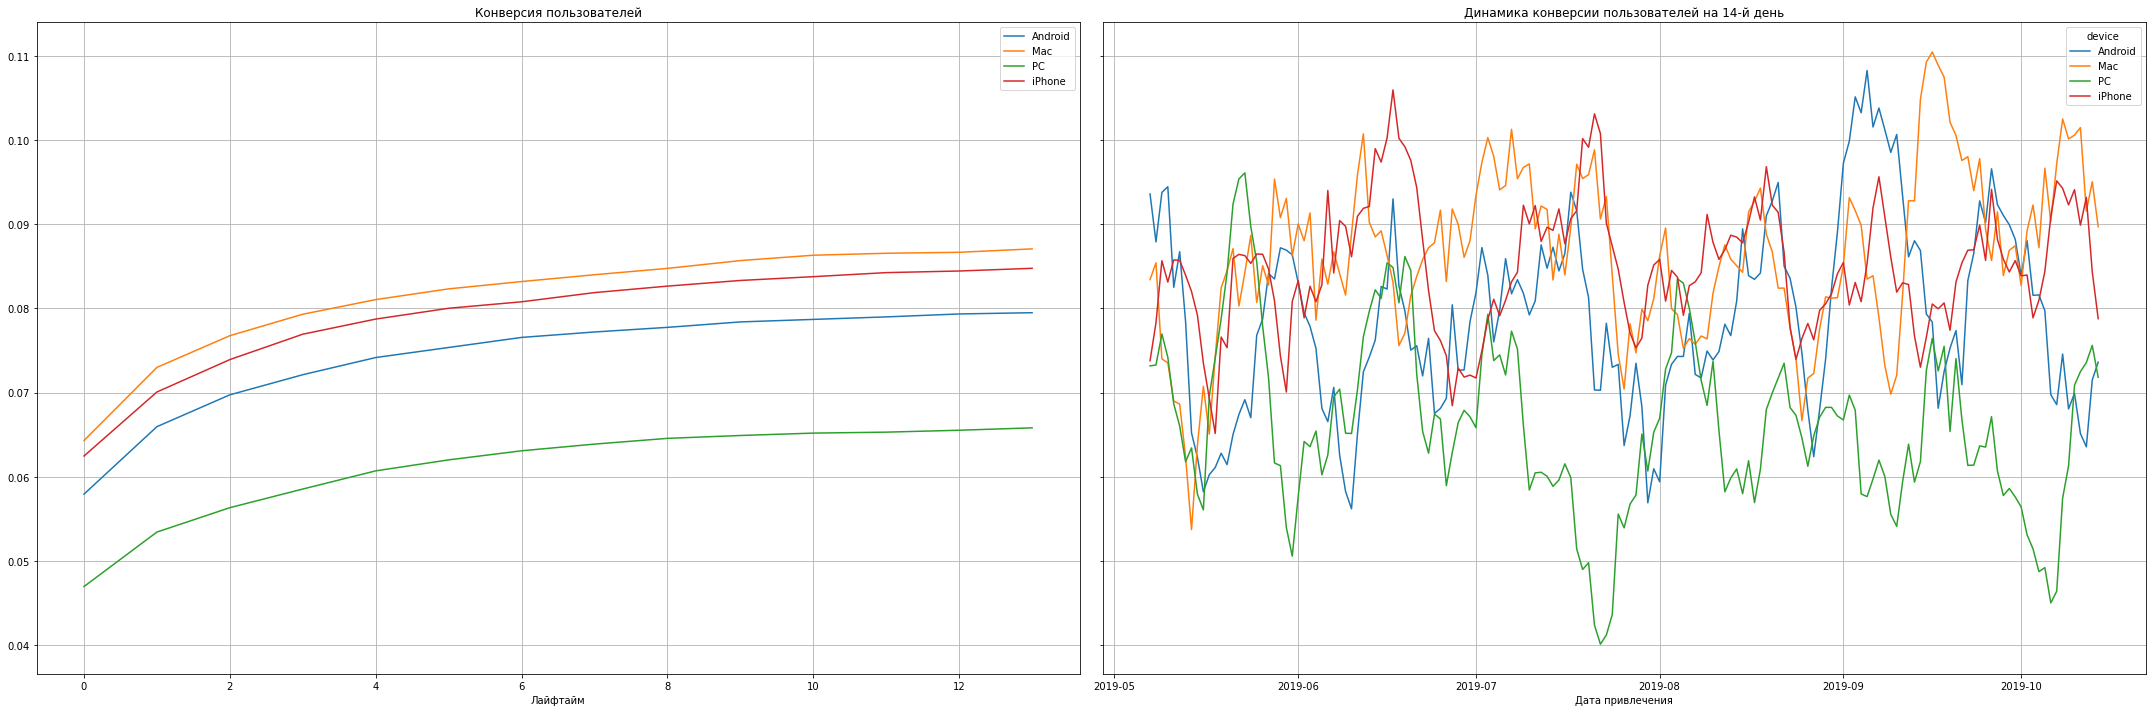

In [35]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profile, orders, observation_date, horizon_days,dimensions = ['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Лучше всего конвертируются в покупателя пользователи Мака почти 9%,затем айфон 8.5%,у андроида 8%, хуже всего у ПК 6.5%

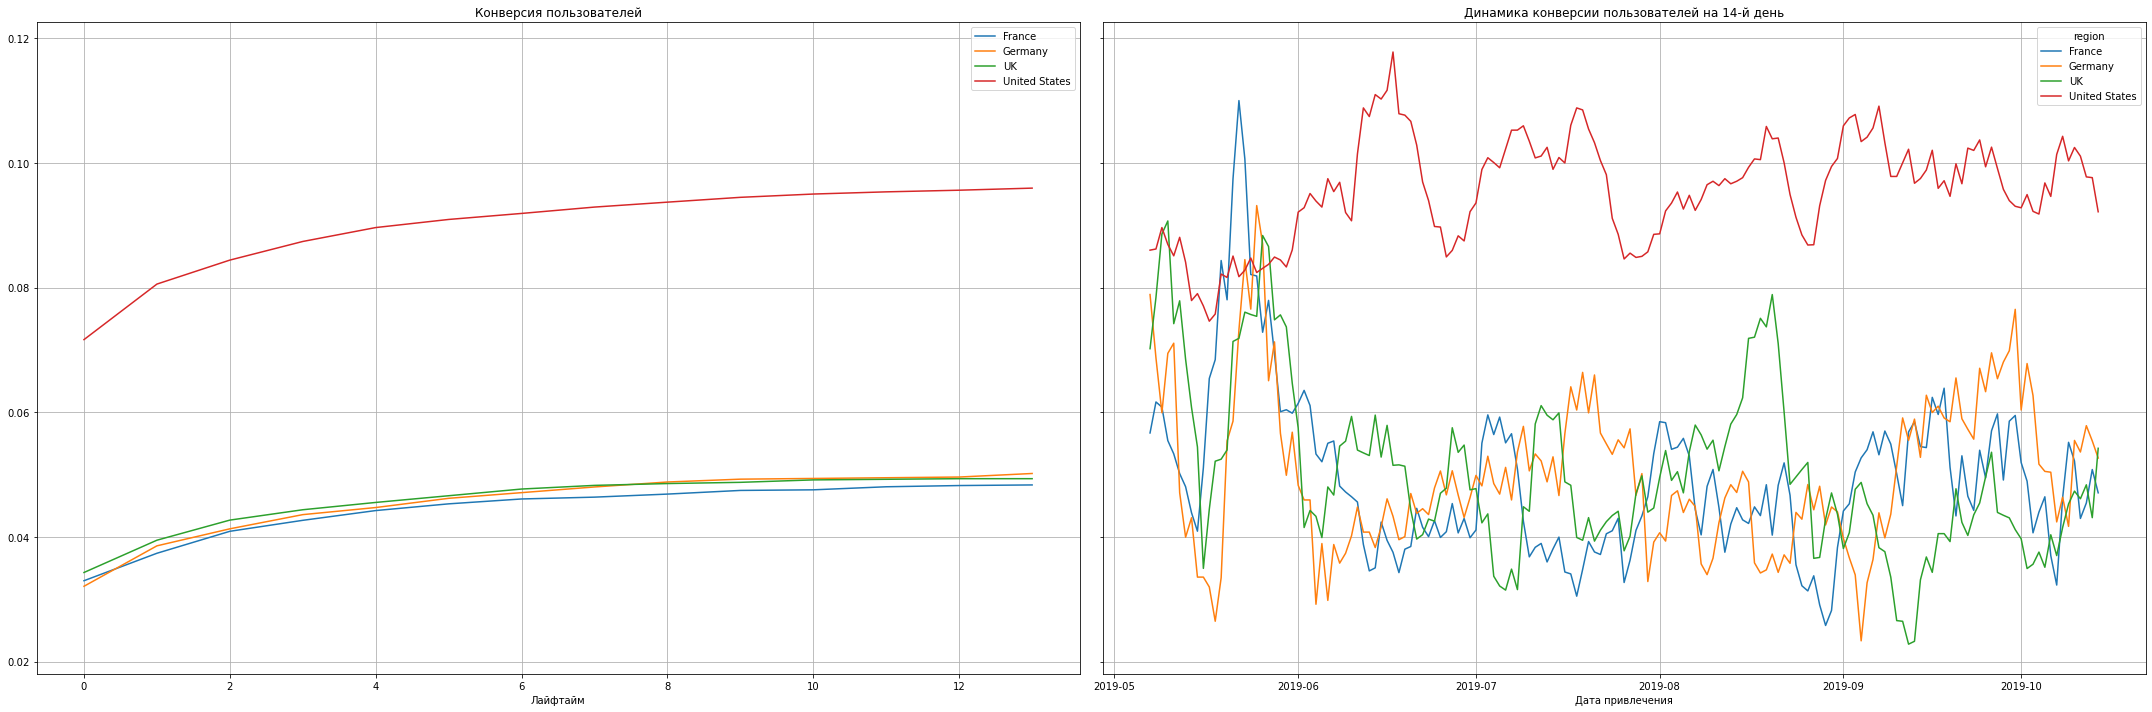

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profile, orders, observation_date, horizon_days,dimensions = ['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Почти 10 % процентов пользователей из США конвертируются в покупатели, что почти в 2 раза больше каждой страны по отдельности 

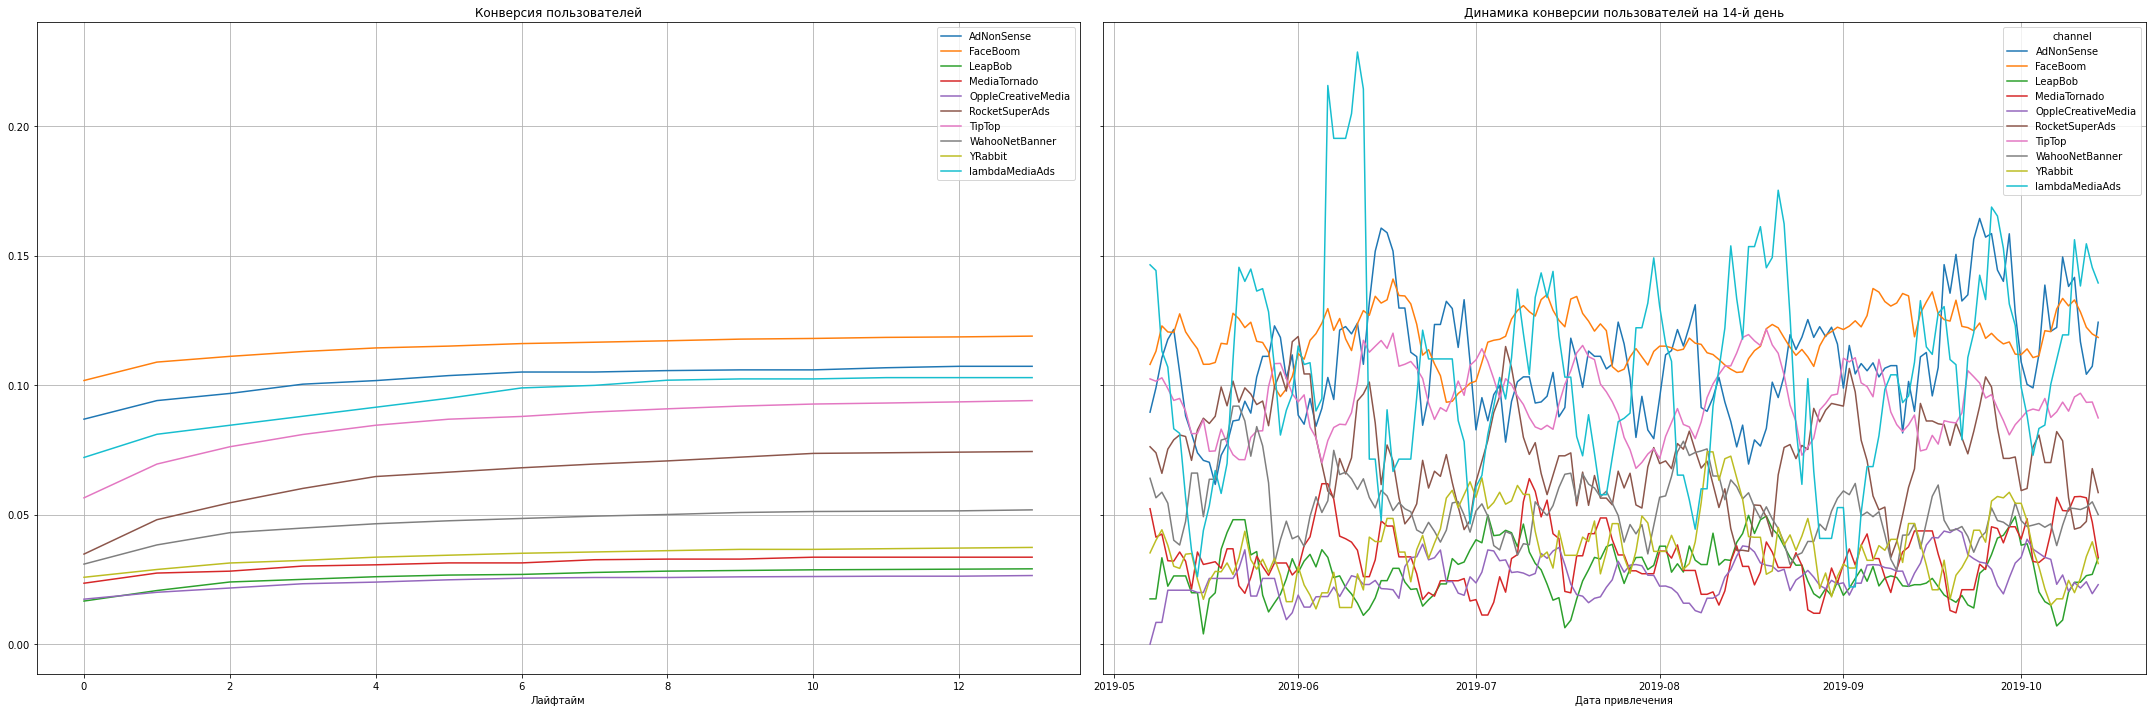

In [37]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profile, orders, observation_date, horizon_days,dimensions = ['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Лучшая конверсия у пользователей из FaceBoom почти 12 процентов,затем AdNonSense 10,7,lambdaMediaAds 10.5 и TipTop 9.5,худшая LeapBob 2,9 % и OppleCreativeMedia 2,6%

#### Вывод
Судя по графика мы наблюдаем спад окупаемости рекламы с июня месяца. Связано это почти с 2 кратным с увеличением стоимости привлечения пользователя в США, из-за этого США оказались единственной страной,которая не смогла пройти точку безубыточности , а так как США наш основной рынок соотвественно идет резкий спад окупаемости,.Что касается 
каналов привлечения , то здесь также идет резкое увеличение стоимости одного пользователя почти в 3.5 раза в TipTop,поэтому пользователи из этого канала не окупились,также не окупились пользователи из канала FaceBoom,у этого канала очень маленький ретеншн - 1.2% , что почти в 20 раз меньше чем лидеров, но у него самая высокая конферсия 12%.Посколько есть проблемы с каналами TipTOP, Faceboom, с регионом США неудевительно ,что реклама не окупилась ,так как основная масса пользователей находится в этом регионе и пришла из этих каналов.

# выводы

Итак мы выяснили ,что пользователями приложения "Procrastinate Pro+" являются жители 4 стран : США, Франции, Германии, Великобритании.Больше всего пользователей из США.Больше всего платящих пользователй также из США.Пользователи приложения "Procrastinate Pro+" предпочитают пользоваться устройствами работающими на платформе андроид, мак, айфон, и ПК.Большинство пользователей используют продукцию эпл. Большинство платящих полоьзователей использует айфон.Общая сумма расходов на маркетинг с 1  мая по 27 октября 2019 года составила  105497.3 $

Однако приложение не может отбить затраты на привлеченных пользователей.Связано это с тем ,что с июня резко выросли затраты на привлечение одного пользователя, особенно в США. Траты на привлечение пользователей из TipTop и FaceBoom не оправдались. Один клиент из TipTop обошелся компании в 2.8 $, что в 3,7 раза больше чем  в среднем из остальных каналов. Что касается девайсов , только пользователи ПК преодолели точку безубыточности. 
Маркетинговому отделу приложения Procrastinate Pro+ необходимо уменьшить расходы на привлечение пользоватлей, особенно это касается каналов TipTop, AdNonSense, FaceBoom, а также сократить расходы на пользователей из США, слишком дорогие и обратить внимание на европейский регион, особенно на Великобританию, так как она показывает лучше ROI.Также следует рассмотреть увеличение бюджета на привлечение пользователей из других каналов, например:YRabbit,MediaTornado,lambdaMediaAds,LeapBob,RocketSuperAds, так как у них самый высокий ROI.